### Loading All the packages

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
import itertools
import math
import cv2
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten,Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix

from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.2.0


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Create our own model with simple architecture

We begin with simple and lightweight convolutional neural network architecture. The dataset is also kept simple and we make use of grayscale images to reduce the computation effort.

In [3]:
print("Training Dataset:\n")
for item in os.listdir("data/processed/Gray/train/"):
    print(str(len(os.listdir("data/processed/Gray/train/" + item))) + " " + item+ " images")

Training Dataset:

1819 Daal-Bhat images
1820 Kathi-Roll images
1820 Laphing images
1820 Paani-Puri images
1820 Yomari images
1820 Chhoila images
1820 Mo:Mo images


In [4]:
print("Validation Dataset:\n")
for item in os.listdir("data/processed/Gray/test/"):
    print(str(len(os.listdir("data/processed/Gray/test/" + item))) + " " + item+ " images")

Validation Dataset:

440 Daal-Bhat images
440 Kathi-Roll images
440 Laphing images
440 Paani-Puri images
439 Yomari images
440 Chhoila images
440 Mo:Mo images


In [5]:
datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator = datagen_train.flow_from_directory(directory="data/processed/Gray/train/",
                                                    target_size=(128, 128),
                                                    color_mode="grayscale",
                                                    batch_size=32,
                                                    class_mode="categorical",
                                                    shuffle=True,
                                                    seed=42)

Found 12739 images belonging to 7 classes.


In [6]:
datagen_validation = ImageDataGenerator()
validation_generator = datagen_validation.flow_from_directory(directory="data/processed/Gray/test/",
                                                              target_size=(128, 128),
                                                              color_mode="grayscale",
                                                              batch_size=32,
                                                              class_mode="categorical",
                                                              shuffle=True,
                                                              seed=42)

Found 3079 images belonging to 7 classes.


In [7]:
model=Sequential()

# Conv-layer-1
model.add(Conv2D(32,(3,3),input_shape=(128,128,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Conv-layer-2
model.add(Conv2D(128,(5,5)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


# Conv-layer-3
model.add(Conv2D(512,(3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


# Conv-layer-4
model.add(Conv2D(512,(3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))


model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 59, 59, 128)       102528    
_________________________________________________________________
batch_normalization_1 (Batch (None, 59, 59, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 59, 59, 128)       0

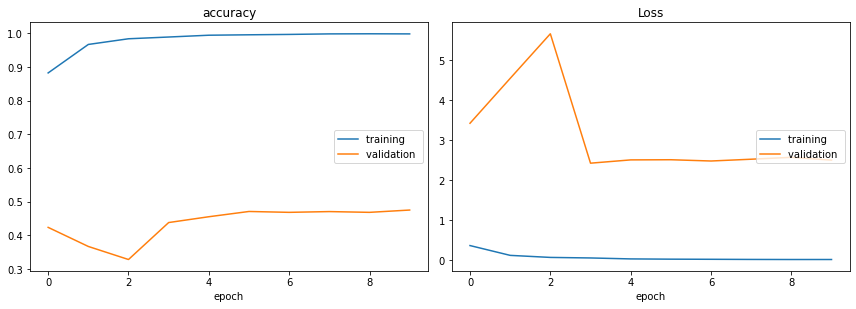

accuracy
	training         	 (min:    0.882, max:    0.998, cur:    0.998)
	validation       	 (min:    0.328, max:    0.475, cur:    0.475)
Loss
	training         	 (min:    0.011, max:    0.360, cur:    0.011)
	validation       	 (min:    2.424, max:    5.665, cur:    2.500)

Epoch 00010: saving model to model_weights.h5
398/398 [==============================] - 410s 1s/step - loss: 0.0112 - accuracy: 0.9980 - val_loss: 2.5002 - val_accuracy: 0.4753 - lr: 1.0000e-05


In [8]:
epochs = 10
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

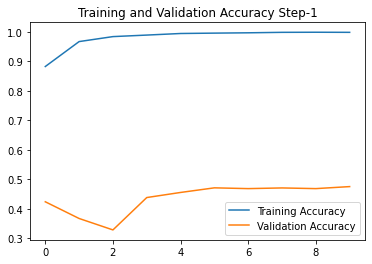

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)


plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy Step-1')

plt.show()



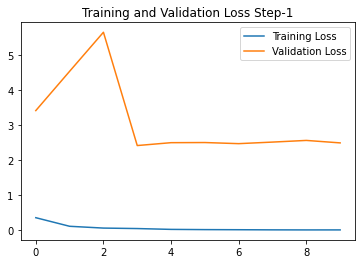

In [19]:

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss Step-1')

plt.show()

From the above plots of `Accuracy` and `Loss` values of training and validation sets, it is clear that the model is severely suffering from overfitting. To get rid of this problem, we can try adding `dropout` and decreasing the number of nodes in dense layers.

   ### Adding `Dropout` Layers and decreasing number of nodes in `Dense` layers

In [20]:
model=Sequential()

# Conv-layer-1
model.add(Conv2D(32,(3,3),input_shape=(128,128,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# Conv-layer-2
model.add(Conv2D(128,(5,5)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))


# Conv-layer-3
model.add(Conv2D(512,(3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# Conv-layer-4
model.add(Conv2D(512,(3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

# Fully connected layer 2nd layer
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
batch_normalization_6 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
activation_6 (Activation)    (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 59, 59, 128)       102528    
_________________________________________________________________
batch_normalization_7 (Batch (None, 59, 59, 128)      

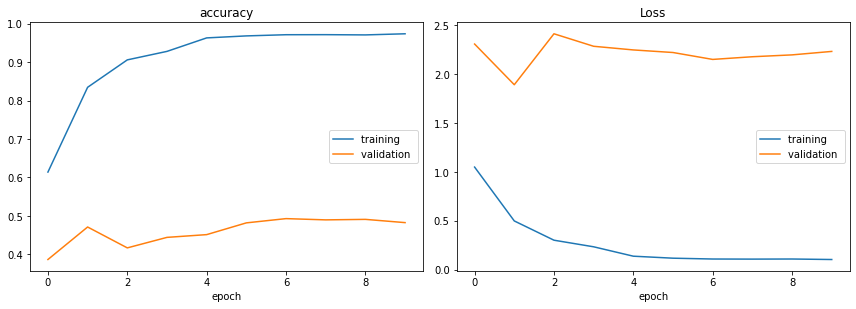

accuracy
	training         	 (min:    0.614, max:    0.974, cur:    0.974)
	validation       	 (min:    0.386, max:    0.493, cur:    0.482)
Loss
	training         	 (min:    0.103, max:    1.049, cur:    0.103)
	validation       	 (min:    1.892, max:    2.413, cur:    2.233)

Epoch 00010: saving model to model_weights_2.h5
398/398 [==============================] - 419s 1s/step - loss: 0.1030 - accuracy: 0.9740 - val_loss: 2.2329 - val_accuracy: 0.4824 - lr: 1.0000e-05


In [21]:
epochs = 10
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights_2.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

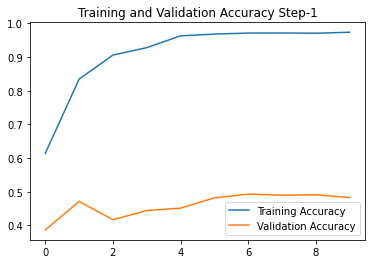

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)


plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy Step-1')

plt.show()

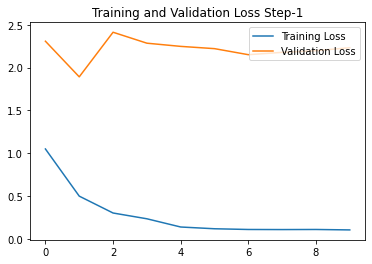

In [23]:
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss Step-1')
plt.show()

The model is still suffering from overfitting problem despite adding dropouts and making the model simple which implies we do not have enough data to train the network. 

### Use Transfer Learning

We can overcome the problem of overfitting using the concept of Transfer Learning. 
There are various state-of-the-art architectures available for Computer Vision. Some of the popular ones are:
* VGG-16
* VGG-19
* Inception V3
* XCeption
* ResNet-50

However, I'm gonna use [MobileNetv2](https://arxiv.org/pdf/1704.04861.pdf) as it lightweight model that can run even on mobile phones. 

At first, we will remove the Fully Connected layers from `MobileNetv2` trained on the `ImageNet` dataset and insert some custom layers. Our output layer will have 7 nodes as we have 7 output classes and each node in the output layer will output the probability of each class.


In [24]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               alpha=1.0,
                                               include_top=False,
                                               weights="imagenet")

In [25]:
for layer in base_model.layers:
    layer.trainable = False

In [26]:
datagen_train = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=45, 
                                   width_shift_range=.15, 
                                   height_shift_range=.15, 
                                   horizontal_flip=True, 
                                   zoom_range=0.5)

train_generator = datagen_train.flow_from_directory(directory="data/processed/RGB/train/",
                                                    target_size=(224,224),
                                                    color_mode="rgb",
                                                    batch_size=32,
                                                    class_mode="categorical",
                                                    shuffle=True,
                                                    seed=42)

Found 12739 images belonging to 7 classes.


In [27]:
datagen_validation = ImageDataGenerator(rescale=1./255)


validation_generator = datagen_validation.flow_from_directory(directory="data/processed/RGB/test/",
                                                              target_size=(224,224),
                                                              color_mode="rgb",
                                                              batch_size=32,
                                                              class_mode="categorical",
                                                              shuffle=True,
                                                              seed=42)

Found 3079 images belonging to 7 classes.


In [28]:
model_transfered_1=Sequential()

model_transfered_1.add(base_model)

# Flattening
model_transfered_1.add(Flatten())

# Fully connected layer 1st layer
model_transfered_1.add(Dense(32))
model_transfered_1.add(BatchNormalization())
model_transfered_1.add(Activation('relu'))
model_transfered_1.add(Dropout(0.4))

# Fully connected layer 2nd layer
model_transfered_1.add(Dense(32))
model_transfered_1.add(BatchNormalization())
model_transfered_1.add(Activation('relu'))
model_transfered_1.add(Dropout(0.4))

model_transfered_1.add(Dense(7, activation='softmax'))

In [29]:
model_transfered_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2007072   
_________________________________________________________________
batch_normalization_12 (Batc (None, 32)                128       
_________________________________________________________________
activation_12 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)               

In [31]:
model_transfered_1.compile(optimizer=Adam(lr=0.0005), 
                         loss='categorical_crossentropy', metrics=['categorical_accuracy'])

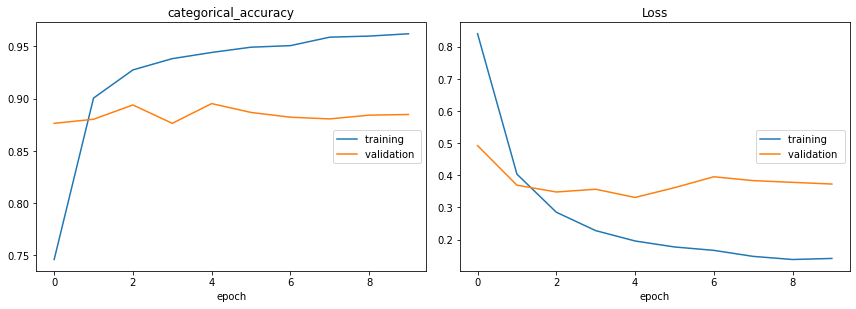

categorical_accuracy
	training         	 (min:    0.746, max:    0.962, cur:    0.962)
	validation       	 (min:    0.876, max:    0.895, cur:    0.885)
Loss
	training         	 (min:    0.138, max:    0.840, cur:    0.141)
	validation       	 (min:    0.331, max:    0.492, cur:    0.373)

Epoch 00010: saving model to trainStep1_mobilenet_weights.h5
398/398 [==============================] - 194s 486ms/step - loss: 0.1414 - categorical_accuracy: 0.9619 - val_loss: 0.3729 - val_categorical_accuracy: 0.8848 - lr: 1.0000e-05


In [32]:
epochs = 10
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("trainStep1_mobilenet_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)


callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

history = model_transfered_1.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks,
    shuffle=True
)

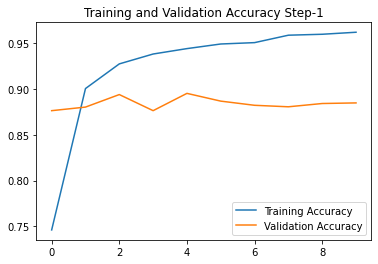

In [35]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)


plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy Step-1')

plt.show()

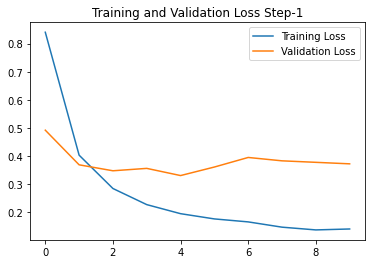

In [36]:
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss Step-1')
plt.show()

We can experiment training some inner layers of model too.


In [37]:
position_block_15 = base_model.get_layer('block_15_add')

In [38]:
for layer in base_model.layers:
    layer.trainable = True

In [39]:
all_layers = base_model.layers
for i in range(base_model.layers.index(position_block_15)):
    all_layers[i].trainable = False

In [41]:
model_transfered_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2007072   
_________________________________________________________________
batch_normalization_12 (Batc (None, 32)                128       
_________________________________________________________________
activation_12 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)               

In [42]:
model_transfered_1.compile(optimizer=Adam(lr=0.0005), 
                         loss='categorical_crossentropy', metrics=['categorical_accuracy'])

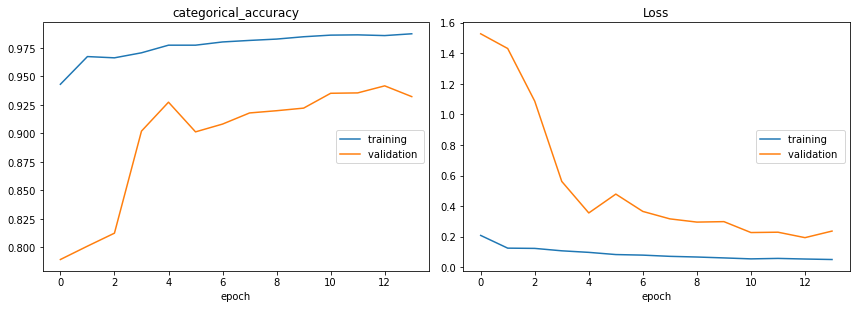

categorical_accuracy
	training         	 (min:    0.943, max:    0.987, cur:    0.987)
	validation       	 (min:    0.789, max:    0.942, cur:    0.932)
Loss
	training         	 (min:    0.051, max:    0.209, cur:    0.051)
	validation       	 (min:    0.194, max:    1.528, cur:    0.237)

Epoch 00014: saving model to trainStep2_mobilenet_weights.h5
398/398 [==============================] - 207s 520ms/step - loss: 0.0513 - categorical_accuracy: 0.9874 - val_loss: 0.2373 - val_categorical_accuracy: 0.9323 - lr: 5.0000e-05


In [43]:
epochs = 14
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("trainStep2_mobilenet_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)


callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

history = model_transfered_1.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks,
    shuffle=True
)

In [44]:
mobilenet02_json = model_transfered_1.to_json()
with open("mobilenet02.json", "w") as json_file:
    json_file.write(mobilenet02_json)

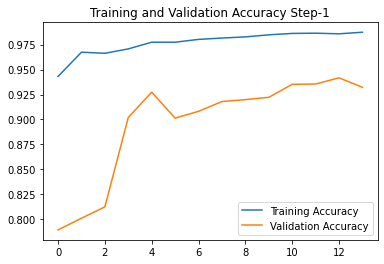

In [46]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(14)


plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy Step-1')

plt.show()

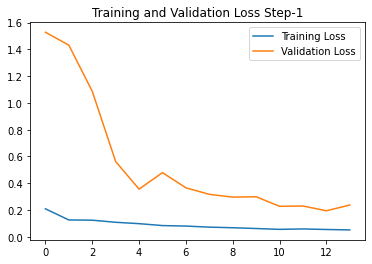

In [47]:
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss Step-1')
plt.show()